In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

import sys
sys.path.append('..')

import modules.stats as st
import modules.plotting as pl
import modules.pandas_funcs as pf

In [2]:
results_dir = os.path.join('..', 'data', 'results')
match_dir = os.path.join('..', 'data', 'matching')


df_k_raw = pd.read_csv(os.path.join(results_dir, 'kinect_gait_metrics.csv'),
                       index_col=0)

df_z_raw = pd.read_csv(os.path.join(results_dir, 'zeno_gait_metrics.csv'),
                       index_col=0)

df_match = pd.read_csv(os.path.join(match_dir, 'match_kinect_zeno.csv'))

# Drop rows where file has no match
df_match = df_match.dropna(axis=0)


df_match_zeno = pd.merge(df_match, df_z_raw, left_on='Zeno', right_index=True)

df_total = pd.merge(df_match_zeno, df_k_raw, left_on='Kinect',
                    right_index=True, suffixes=('_z', '_k'))


# Take columns from total DataFrame to get Kinect and Zeno data
df_k = df_total.filter(like='_k')
df_z = df_total.filter(like='_z')

# Remove suffixes from column names
df_k = df_k.rename(columns=lambda x: str(x)[:-2])
df_z = df_z.rename(columns=lambda x: str(x)[:-2])

# Group by gait metric without suffix
df_k_grouped = df_k.groupby(lambda x: x[:-2], axis=1).mean()
df_z_grouped = df_z.groupby(lambda x: x[:-2], axis=1).mean()

## Visual Results

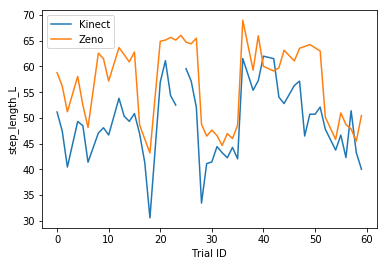

In [3]:
%matplotlib inline

metric = 'step_length_L'

plt.plot(df_k[metric])
plt.plot(df_z[metric])

plt.xlabel('Trial ID')
plt.ylabel(metric)

plt.legend(['Kinect', 'Zeno'])
plt.show()

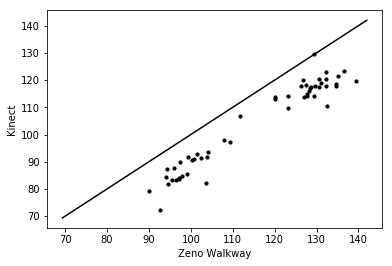

In [4]:
x_label, y_label = 'Zeno Walkway', 'Kinect'
metric = 'stride_length_R'
    
pl.compare_measurements(df_z[metric], df_k[metric], c='k', s=10)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.show()

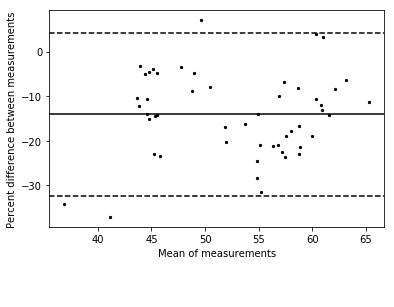

In [5]:
metric = 'step_length_L'

# Bland-Altman object
bland_obj = st.BlandAltman(df_k[metric], df_z[metric], percent=True)

pl.plot_bland_altman(bland_obj.means, bland_obj.differences, bland_obj.bias, 
                     bland_obj.limits_of_agreement, percent=True)

## Quantitative Results

,step_length,stride_width,stride_length,stride_velocity,stride_time
Abs rel error,0.131571,2.511053,0.113158,0.094367,0.173631
Bias,-0.141853,0.802307,-0.120340,0.065786,-0.192816
Pearson,0.943421,0.811268,0.949321,0.957087,0.945320
Range,0.184577,4.195962,0.180910,0.323054,0.304009
Spearman,0.874669,0.739947,0.869547,0.823188,0.723729


In [17]:
funcs = {'Pearson': lambda a, b: pearsonr(a, b)[0],
        'Spearman': lambda a, b: spearmanr(a, b)[0],
        'Abs rel error': lambda a, b: st.relative_error(a, b, absolute=True).mean(),
        'Bias': lambda a, b: st.BlandAltman(a, b).bias, 
        'Range': lambda a, b: st.BlandAltman(a, b).range}
 
    
d = {name: pf.apply_to_columns(df_k, df_z, func) for name, func in funcs.items()}

df_results = pd.DataFrame(d).T
df_results

,step_length_L,step_length_R,stride_length_L,stride_length_R,stride_time_L,stride_time_R,stride_velocity_L,stride_velocity_R,stride_width_L,stride_width_R
Pearson,0.794103,0.928011,0.874005,0.967355,0.930738,0.933552,0.931118,0.967533,0.708079,0.814970
Spearman,0.780000,0.893366,0.840271,0.922883,0.723331,0.726593,0.797466,0.862119,0.625701,0.744472
Abs rel error,0.133992,0.137588,0.127475,0.102616,0.173546,0.172875,0.097608,0.096517,4.668738,4.882894
Bias,-0.140968,-0.145140,-0.133875,-0.108876,-0.193365,-0.192292,0.052816,0.076093,0.858137,0.756244
Range,0.366154,0.239478,0.267324,0.162734,0.338649,0.326009,0.388214,0.306603,5.429426,3.426554


In [18]:
d = {name: pf.apply_to_columns(df_k_grouped, df_z_grouped, func) for name, func in funcs.items()}

df_grouped = pd.DataFrame(d).T
df_grouped

,step_length,stride_length,stride_time,stride_velocity,stride_width
Pearson,0.943421,0.949321,0.945320,0.957087,0.811268
Spearman,0.874669,0.869547,0.723729,0.823188,0.739947
Abs rel error,0.131571,0.113158,0.173631,0.094367,2.511053
Bias,-0.141853,-0.120340,-0.192816,0.065786,0.802307
Range,0.184577,0.180910,0.304009,0.323054,4.195962


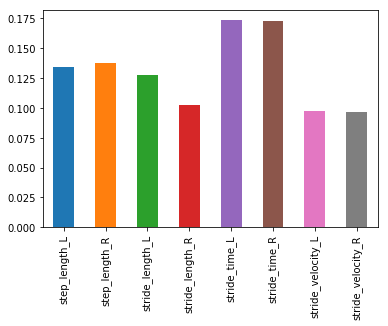

In [8]:
df_results.loc['Abs rel error'][:-2].plot.bar()

In [9]:
df_sides = df_results.groupby(lambda x: x.split('_')[-1], axis=1).mean()
df_sides

,L,R
Pearson,0.847608,0.922284
Spearman,0.753354,0.829887
Abs rel error,1.040272,1.078498
Bias,0.088549,0.077206
Range,1.357953,0.892275
